In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the data

In [56]:
if torch.backends.mps.is_available():
    print("Using Apple M3 pro GPU")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

device = torch.device("cpu")

Using Apple M3 pro GPU


In [57]:
def load_data(file_path):
    data = torch.load(file_path)
    # the section .to(torch.float32) is because of macbook m3 pro gpu
    # return data['samples'].to(torch.float32), data['labels']
    # for cpu
    return data['samples'], data['labels']
train_samples, train_labels = load_data(".data/train.pt")
test_samples, test_labels = load_data(".data/test.pt")
val_samples, val_labels = load_data(".data/val.pt")

/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_75966/809197571.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


# Data exploration


In [58]:
print("Train Samples Shape:", train_samples.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Samples Shape:", test_samples.shape)
print("Test Labels Shape:", test_labels.shape)
print("Validation Samples Shape:", val_samples.shape)
print("Validation Labels Shape:", val_labels.shape)

Train Samples Shape: torch.Size([5881, 3, 206])
Train Labels Shape: torch.Size([5881])
Test Samples Shape: torch.Size([2947, 3, 206])
Test Labels Shape: torch.Size([2947])
Validation Samples Shape: torch.Size([1471, 3, 206])
Validation Labels Shape: torch.Size([1471])


In [59]:
train_labels.unique()

tensor([0., 1., 2., 3., 4., 5.], dtype=torch.float64)

In [60]:
def plot_sample(sample, label, channels=['Channel 1', 'Channel 2', 'Channel 3']):
    timesteps = sample.shape[1]
    plt.figure(figsize=(12, 6))
    for i in range(sample.shape[0]):
        plt.plot(range(timesteps), sample[i], label=channels[i])
    plt.title(f"Sample Data for Label: {label}")
    plt.xlabel("Timesteps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

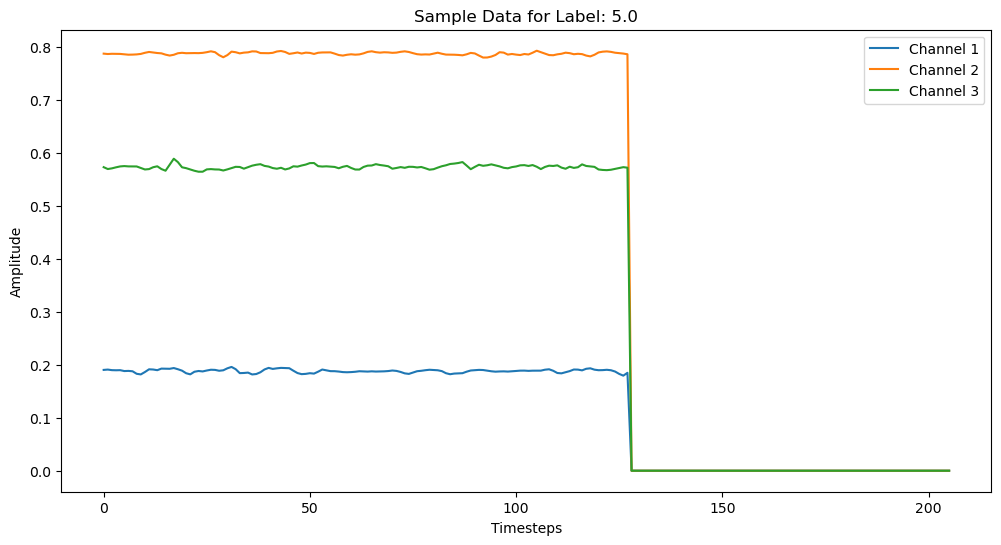

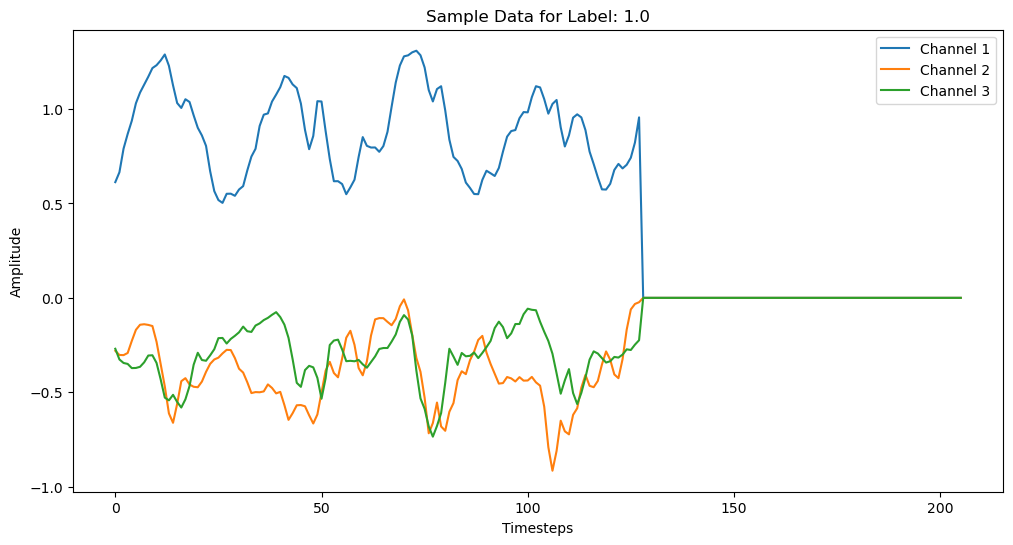

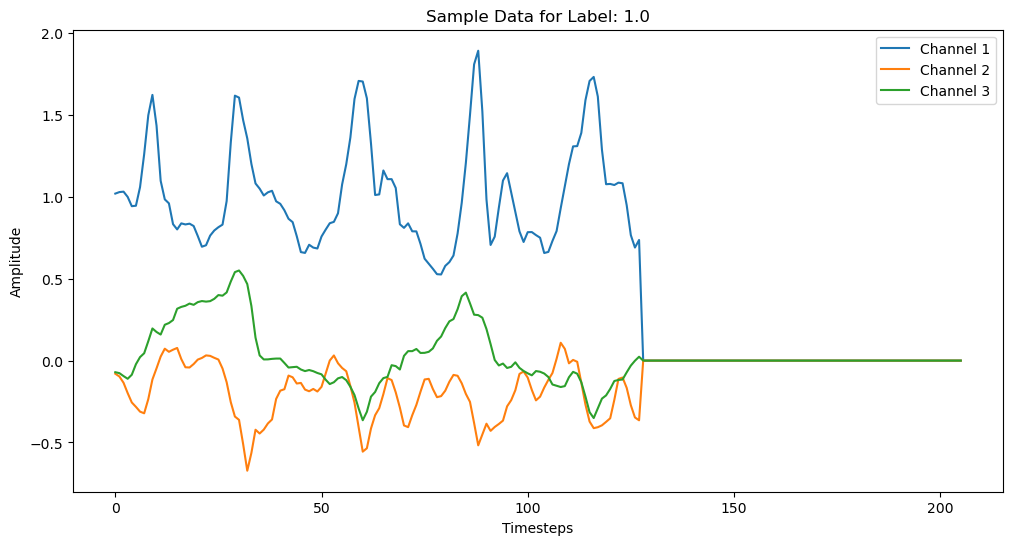

In [39]:
for i in range(3):
    plot_sample(train_samples[i].numpy(), train_labels[i].item())

# Meaning of dimensions:
# - Samples: Number of examples
# - Channels: Number of sensor channels (e.g., accelerometer axes: x, y, z)
# - Timesteps: Sequence length per example (e.g., 206 timesteps per sample)

In [ ]:
# transform train, test timesteps from 206 to 128
# TODO: add transform_samples function
def transform_samples(samples):
    return nn.functional.interpolate(samples, size=128)

In [61]:
# Define dataset and DataLoader
def create_dataloader(samples, labels, batch_size=64):
    dataset = TensorDataset(samples, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(train_samples, train_labels)
val_loader = create_dataloader(val_samples, val_labels)
test_loader = create_dataloader(test_samples, test_labels, batch_size=1)

# Define the RNN model

## Using Global Average Pooling Across All Timesteps

In [96]:
class RNNClassifierWithPooling(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifierWithPooling, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        # LSTM expects (batch_size, timesteps, input_size)
        out, _ = self.rnn(x)
        
        # Global Average Pooling: Average over all timesteps
        out = out.mean(dim=1)  # Take the average across timesteps (dim=1)
        
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Model parameters
input_size = train_samples.shape[2]  # Number of features per timestep
hidden_size = 256  
num_layers = 2 
num_classes = len(torch.unique(train_labels))  # Number of classes
learning_rate = 0.001
epochs = 50

# Instantiate the model


In [97]:
model = RNNClassifierWithPooling(input_size, hidden_size, num_layers, num_classes)
model.to(device)
# model = model.to(torch.float32)  # Ensure model weights are in float32
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Model loops

In [98]:
# Training loop
def train_model(model, train_loader, val_loader, epochs):
    best_val_acc = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_acc = validate_model(model, val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}, Val Accuracy: {val_acc:.2f}%")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model

# Validation loop
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()

    return 100 * correct / total

# Test loop
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    accuracy = 100 * correct / total
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, digits=4))

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy


Epoch 1/50, Loss: 1.2243, Val Accuracy: 53.98%
Epoch 2/50, Loss: 0.9535, Val Accuracy: 56.15%
Epoch 3/50, Loss: 0.9322, Val Accuracy: 57.92%
Epoch 4/50, Loss: 0.9232, Val Accuracy: 56.56%
Epoch 5/50, Loss: 0.8925, Val Accuracy: 58.74%
Epoch 6/50, Loss: 0.8671, Val Accuracy: 59.62%
Epoch 7/50, Loss: 0.8394, Val Accuracy: 64.24%
Epoch 8/50, Loss: 0.7605, Val Accuracy: 74.92%
Epoch 9/50, Loss: 0.5892, Val Accuracy: 77.43%
Epoch 10/50, Loss: 0.4353, Val Accuracy: 82.73%
Epoch 11/50, Loss: 0.3612, Val Accuracy: 86.47%
Epoch 12/50, Loss: 0.2924, Val Accuracy: 88.78%
Epoch 13/50, Loss: 0.2511, Val Accuracy: 89.46%
Epoch 14/50, Loss: 0.2497, Val Accuracy: 88.31%
Epoch 15/50, Loss: 0.2197, Val Accuracy: 89.06%
Epoch 16/50, Loss: 0.2065, Val Accuracy: 91.09%
Epoch 17/50, Loss: 0.1857, Val Accuracy: 90.35%
Epoch 18/50, Loss: 0.1637, Val Accuracy: 90.21%
Epoch 19/50, Loss: 0.1451, Val Accuracy: 92.05%
Epoch 20/50, Loss: 0.1351, Val Accuracy: 92.05%
Epoch 21/50, Loss: 0.1242, Val Accuracy: 93.20%
E

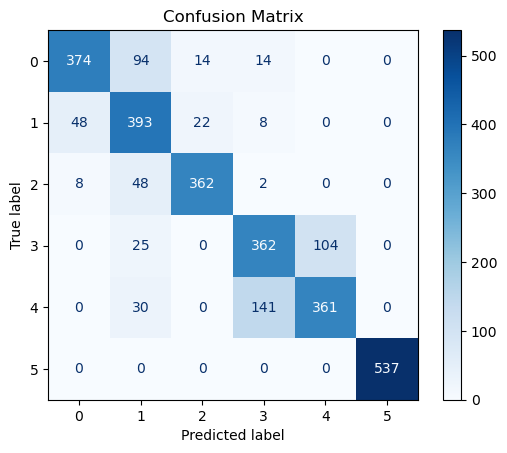

Test Accuracy: 81.07%


In [99]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, epochs)

# Test the model
test_accuracy = test_model(trained_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


In [100]:
#recall and precision
from sklearn.metrics import precision_score, recall_score
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs.float())
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.8181
Recall: 0.8110
